In [33]:
!pip install python-docx
import re
import os
import math
import datetime
import statistics
import comtypes.client
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from docx import Document
from docx.shared import Inches
from docx.enum.style import WD_STYLE_TYPE
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
from io import BytesIO



#Função para localizar e substituir em arquivos docx
def docx_substitui(doc_obj, regex, replace):
    """Localizar e Substituir
    
    Essa função realiza uma busca nos parágrafos e tabelas usando regex,
    em objeto docx.Document e substitui pelo replace.
    """
    for p in doc_obj.paragraphs:
        if regex.search(p.text):
            inline = p.runs
            for i in range(len(inline)):
                if regex.search(inline[i].text):
                    text = regex.sub(replace, inline[i].text)
                    inline[i].text = text
                    
    for table in doc_obj.tables:
        for row in table.rows:
            for cell in row.cells:
                docx_substitui(cell, regex, replace)
                
#Função para converter docx para pdf
def converte_pdf(arqdoc, arqpdf):
    wdFormatPDF = 17
    word = comtypes.client.CreateObject('Word.Application')
    doc = word.Documents.Open(arqdoc)
    doc.SaveAs(arqpdf, FileFormat=wdFormatPDF)
    doc.Close()
    word.Quit()
    return
    
#Função para calcular incertezas
def computa(linha):
    global media_arit
    global varianca_pop
    global desvio_padrao
    global incert_a
    global incert_resol_dig
    global incert_resol_analog
    global incert_padrao
    global incert_comb
    global incert_final
    media_arit = statistics.mean(a[linha][1:]) #Calculo Media aritmetica simples
    varianca_pop = statistics.pvariance(a[linha][1:]) #Calculo  Variança Populacional
    desvio_padrao = statistics.stdev(a[linha][1:]) #Calculo  Desvio padrão
    incert_a = desvio_padrao / math.sqrt(len(a)) #Calculo Incerteza A
    incert_resol_dig = float(res) / math.sqrt(3) #Calculo Incerteza Resolução Analog.
    incert_resol_analog = float(res) / math.sqrt(6) #Calculo Incerteza Resolução Dig.
    incert_padrao = float(pad) / 2 #Calculo Incerteza Padrão
    incert_comb = math.sqrt((incert_a**2)+(incert_resol_analog**2)+(incert_padrao**2)) #Calculo Incerteza Combinada
    incert_final = incert_comb * 2 #Calculo Incerteza Final
    return

In [5]:
#Coleta das informações gerais
id_laudo = input('Informe o número do laudo:')
obj = input('Informe o nome do objeto a ser aferido: ')
fabr = input('Informe o nome do Fabricante: ')
serial = input('Informe o número de série do objeto: ')
data = datetime.date.today().strftime('%d/%m/%Y')
un = input('Informe a unidade de medida: ')
esc = input('Informe a escala do objeto: ')
res = input('Informe a resolução do objeto: ').replace(",", ".")
pad = input('Informe a resolução do padrão: ').replace(",", ".")
tecn = input('Informe o nome do responsável: ')
pontos = int(input('Defina quantos pontos serão coletados: '))
ciclos = int(input('Defina quanos ciclos serão realizados: '))


campos = {'ID_LAUDO': id_laudo, 'OBJ': obj, 'FABR': fabr,
        'SERIAL': serial, 'DATA': data, 'UN': un,
        'ESC': esc, 'RES': res, 'PAD': pad, 'TECN': tecn}
#info_calib = {'PONTOS': pontos, 'CICLOS': ciclos}
pontos += 1
ciclos = ciclos*2+1

Informe o número do laudo:001
Informe o nome do objeto a ser aferido: Manômetro
Informe o nome do Fabricante: Wurth
Informe o número de série do objeto: R232F234F
Informe a unidade de medida: bar
Informe a escala do objeto: 0 a 30
Informe a resolução do objeto: 0,5
Informe a resolução do padrão: 0,001
Informe o nome do responsável: Luiz Gatão
Defina quantos pontos serão coletados: 6
Defina quanos ciclos serão realizados: 3


In [6]:
#Criando array para armazenar leituras
a = np.zeros((ciclos, pontos), dtype=float)

In [ ]:
i = 0 #Controle do laço de repetição
c = 0 #Controle da iteração do Ciclo
d = 1 #Contador de ciclos
while i < len(a):
    j = 0 #Controle do laço de repetição para mudar de array
    while j < len(a[i]):
        if i == 0:
            x = float(input('Informe o ponto {}: '.format(j)))
            a[i][j] = x
            j += 1
        elif i % 2 == 0:
            x = float((input('Informe o elemento Descendente Ciclo {}, {} pontos: '.format(d, a[0][j])).replace(",", ".")))
            a[i][j] = x
            j += 1
        else:
            x = float((input('Informe o elemento Ascendente Ciclo {}, {} pontos: '.format(d, a[0][j])).replace(",", ".")))
            a[i][j] = x
            j += 1
    #Iteração para contagem de ciclos
    if (c % 2 == 0) & (c != 0):
        d += 1
    c += 1
    i += 1
    

In [7]:
#''' Preecher matriz, usado em testes
a = np.array([[ 5. , 10. , 15. , 20. , 25. , 30. ],
[ 5.2,  9.9, 15.1, 20.1, 25.2, 30. ],
[ 5.1,  9.9, 14.9, 20.1, 25.1, 30.1],
[ 4.9,  9.8, 14.9, 20.1, 25.1, 29.9],
[ 4.9,  9.9, 15.2, 20.1, 24.9, 30.1],
[ 5. , 10.1, 15. , 19.9, 24.9, 30. ],
[ 5.1 , 10.1, 14.9, 20. , 24.9, 30. ]])
#'''

In [8]:
#Transpor a matriz para facilitar a criação da tabela
a = a.T

In [9]:
#Criar array vazio para armazenar resultados
b = np.zeros((pontos-1,9), dtype=float)

In [10]:
#Copiar os pontos da matriz a
i = 0
while i < len(b):
    b[i][0] = a[i][0]
    i += 1

In [11]:
#Calcular e inserir na matriz os resultados
i = 0
while i < len(b):
    computa(i)
    b[i][1] = round(media_arit, 4)
    b[i][2] = round(varianca_pop, 4)
    b[i][3] = round(desvio_padrao, 4)
    b[i][4] = round(incert_a, 4)
    b[i][5] = round(incert_resol_analog, 4)
    b[i][6] = round(incert_padrao, 4)
    b[i][7] = round(incert_comb, 4)
    b[i][8] = round(incert_final, 4)
    i += 1
        

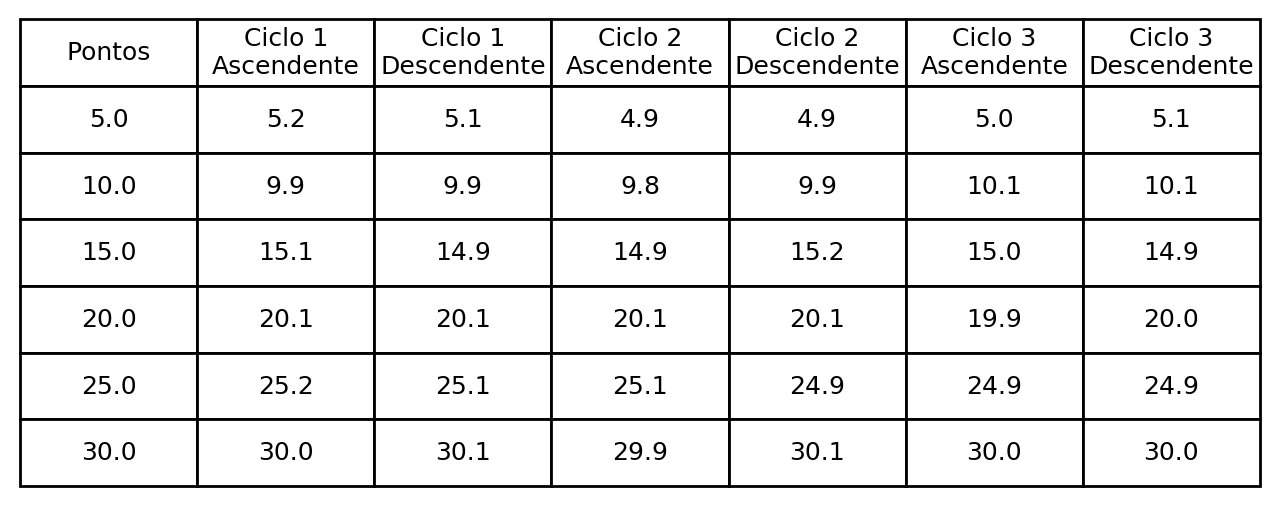

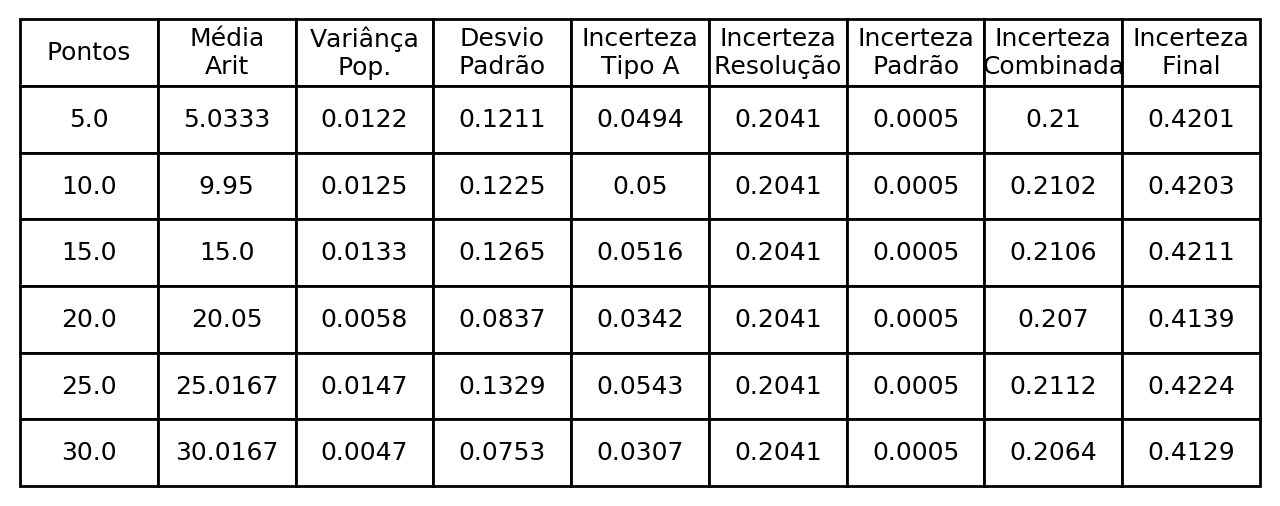

In [40]:
#Gerar Relatorio
arquivo = "Templates/laudo_afericao.docx"
arquivodoc = "resultado.docx"
arquivopdf = "resultado.pdf"

#Informações gerais
doc = Document(arquivo)
for x in campos:
    localizar = re.compile(x)
    info = campos[x]
    docx_substitui(doc, localizar, info)
    
#Definir estilo para Título
doc_styles = doc.styles
doc_charstyle = doc_styles.add_style('Heading', WD_STYLE_TYPE.PARAGRAPH)
doc_font = doc_charstyle.font
doc_font.size = Pt(12)
doc_font.name = 'Arial'

p = doc.add_paragraph(style='Heading')
p.add_run('\n\n') #Quebra de linha
p.add_run('MEDIDAS AFERIDAS').bold = True
p.alignment = WD_ALIGN_PARAGRAPH.CENTER

#Tabela de aferição
memoria = BytesIO()
fig, ax = plt.subplots(dpi=200,  figsize=(4,2))
collabel=('Pontos', 'Ciclo 1\nAscendente', 'Ciclo 1\nDescendente',
          'Ciclo 2\nAscendente', 'Ciclo 2\nDescendente',
          'Ciclo 3\nAscendente', 'Ciclo 3\nDescendente')
ax.axis('tight')
ax.axis('off')
tabela = ax.table(cellText=a,colLabels=collabel,
                  loc='center', cellLoc='center')
#Configurar fonte para tabela de aferição
tabela.auto_set_font_size(False)
tabela.set_fontsize(9)
tabela.scale(2,2)

plt.savefig(memoria, bbox_inches='tight')
doc.add_picture(memoria)

doc.add_page_break() #Quebra de página

p = doc.add_paragraph(style='Heading')
p.add_run('\n\n\n\n\n\n') #Quebra de linha
p.add_run('RESULTADO\n').bold = True
p.alignment = WD_ALIGN_PARAGRAPH.CENTER

#Tabela de resultado
memoria = BytesIO()
fig, ax = plt.subplots(dpi=200, figsize=(4,2))
collabel=('Pontos', 'Média\nArit', 'Variânça\nPop.',
          'Desvio\nPadrão', 'Incerteza\nTipo A',
          'Incerteza\nResolução', 'Incerteza\nPadrão',
          'Incerteza\nCombinada', 'Incerteza\nFinal')
ax.axis('tight')
ax.axis('off')
tabela2 = ax.table(cellText=b,colLabels=collabel,
                  loc='center', cellLoc='center')
#Configurar fonte para tabela de resultado
tabela2.auto_set_font_size(False)
tabela2.set_fontsize(9)
tabela2.scale(2,2)
        
plt.savefig(memoria, bbox_inches='tight')
doc.add_picture(memoria)
    
doc.save(arquivodoc)
memoria.close()

#Converte docx para pdf
converte_pdf(os.path.abspath(arquivodoc), os.path.abspath(arquivopdf))